# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 856.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 354.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 398.4 kB/s eta 0:00:0000:0100:01


In [21]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [24]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=False  # Load initially without parsing dates
).dropna()

# Convert the index to datetime format with the correct format
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index, format='%m/%d/%y %H:%M', errors='coerce')

# Drop any rows where the datetime conversion failed (if applicable)
df_mercado_trends = df_mercado_trends.dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [17]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


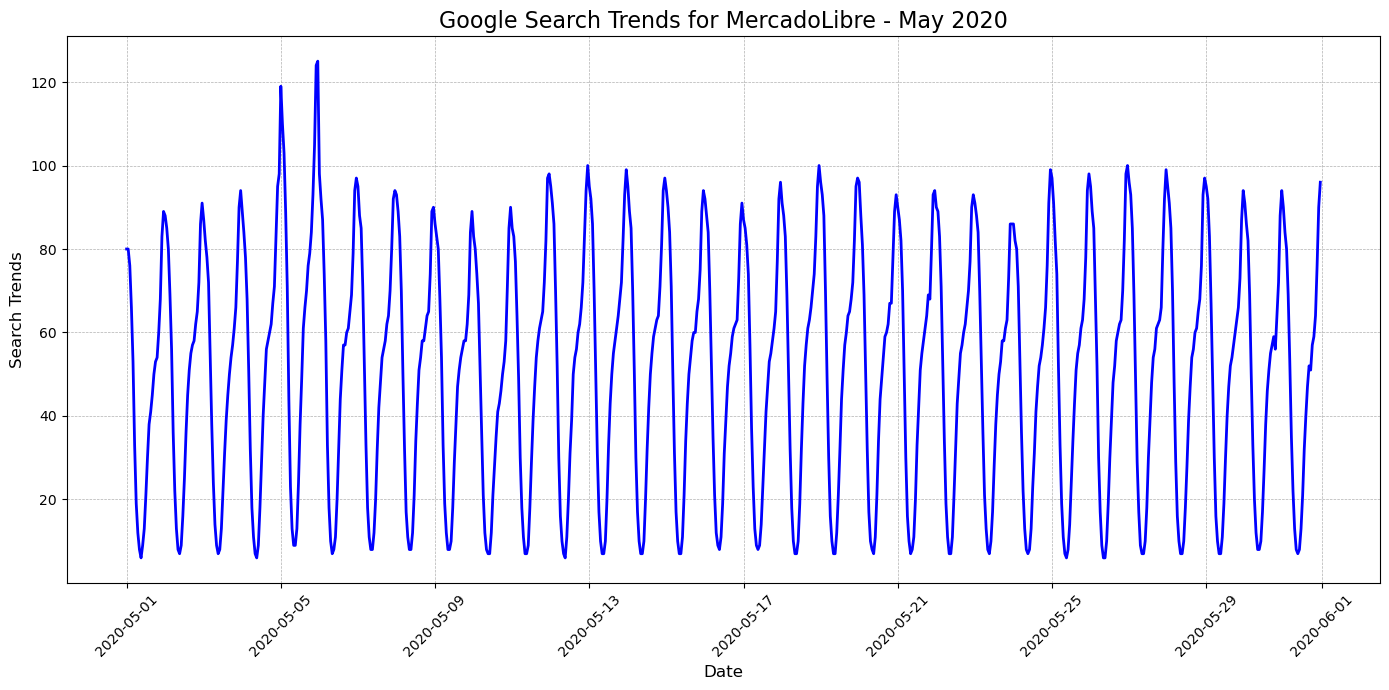

In [26]:
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends['2020-05-01':'2020-05-31']

# Create a plot to visualize the data for May 2020 with additional styling
plt.figure(figsize=(14, 7))
plt.plot(may_2020_data.index, may_2020_data['Search Trends'], color='blue', linewidth=2)
plt.title("Google Search Trends for MercadoLibre - May 2020", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Trends", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [28]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = may_2020_data['Search Trends'].sum()

# View the traffic_may_2020 value
print("Total search traffic for May 2020:")
print(traffic_may_2020)


Total search traffic for May 2020:
38181


In [32]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic = df_mercado_trends.resample('ME').sum()
median_monthly_traffic = monthly_traffic['Search Trends'].median()

# View the median_monthly_traffic value
print("Median monthly search traffic across all months:")
print(median_monthly_traffic)

Median monthly search traffic across all months:
35172.5


In [34]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
comparison_ratio = traffic_may_2020 / median_monthly_traffic

# View the comparison ratio
print("Comparison of May 2020 search traffic to the overall monthly median:")
print(comparison_ratio)

Comparison of May 2020 search traffic to the overall monthly median:
1.0855355746677091


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic did increase during the month that MercadoLibre released its financial results. The total search traffic for May 2020 was approximately 8.55% higher than the median monthly search traffic across all months. This indicates an uptick in search activity that coincided with the release of the financial results, suggesting increased interest in the company during this period.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

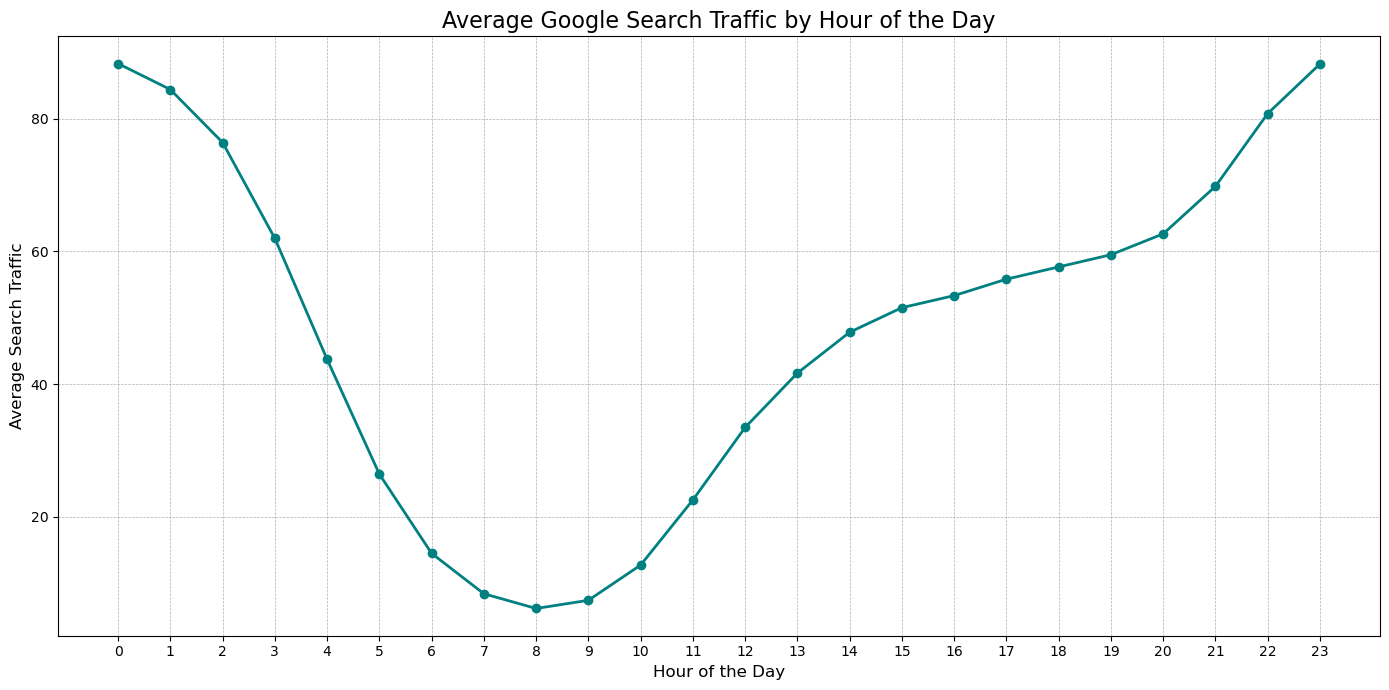

In [41]:
# Group the hourly search data to plot the average traffic by the hour of day, using `df.index.hour`
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

# Create a plot with custom styling
plt.figure(figsize=(14, 7))
plt.plot(hourly_traffic.index, hourly_traffic['Search Trends'], marker='o', linestyle='-', color='teal', linewidth=2)
plt.title('Average Google Search Traffic by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(hourly_traffic.index, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

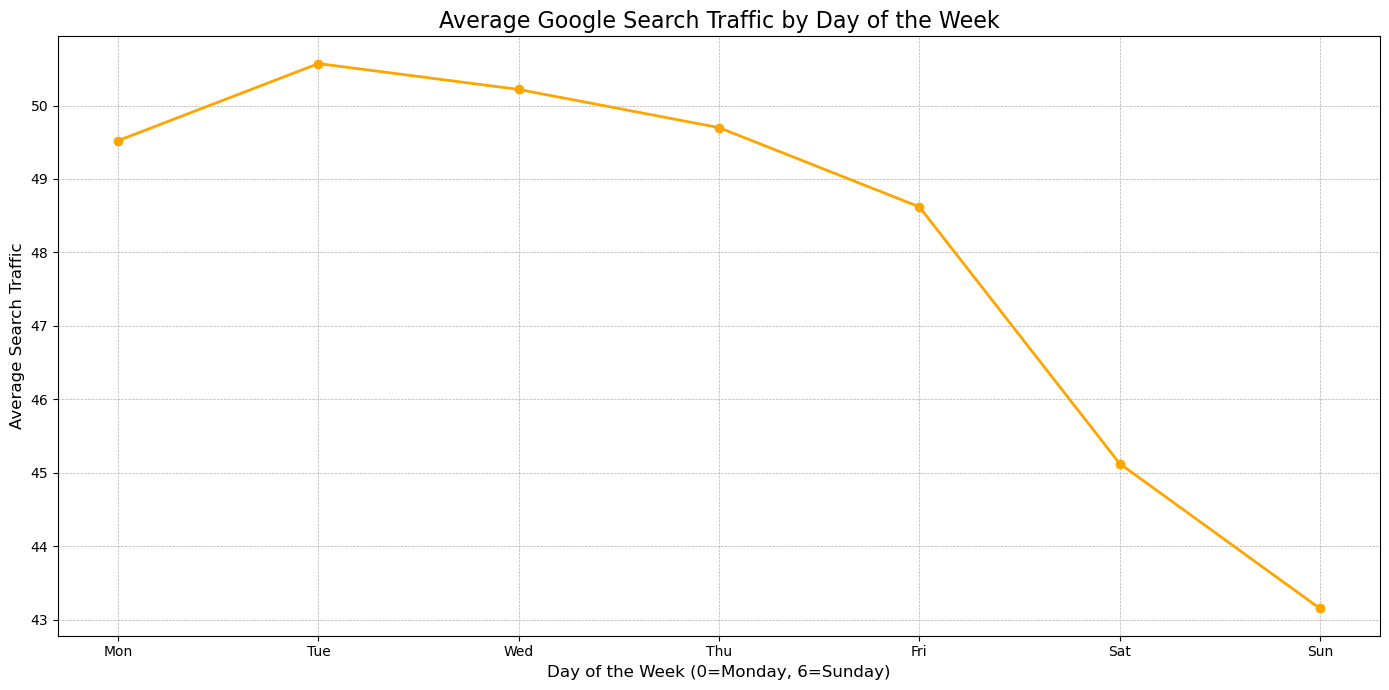

In [43]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`
daily_traffic = df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean()

# Create a plot with custom styling
plt.figure(figsize=(14, 7))
plt.plot(daily_traffic.index, daily_traffic['Search Trends'], marker='o', linestyle='-', color='orange', linewidth=2)
plt.title('Average Google Search Traffic by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(daily_traffic.index, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

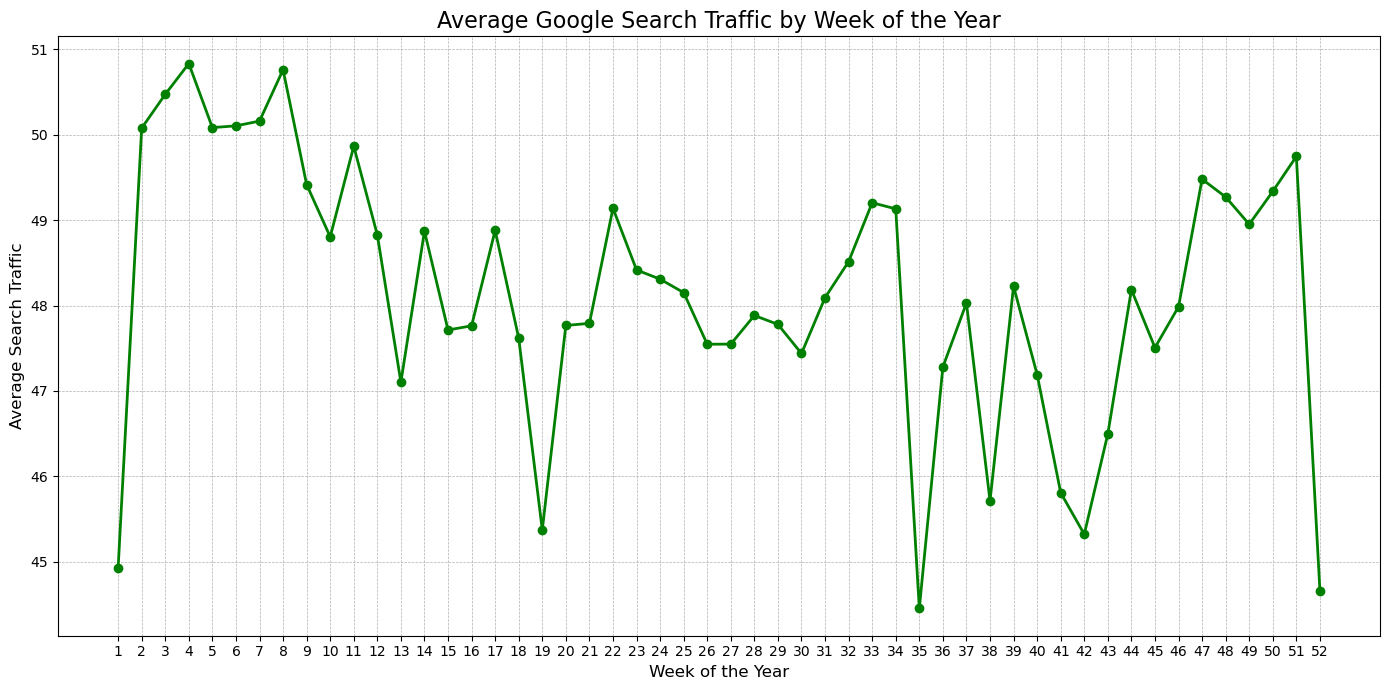

In [45]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`
weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

# Create a plot with custom styling
plt.figure(figsize=(14, 7))
plt.plot(weekly_traffic.index, weekly_traffic['Search Trends'], marker='o', linestyle='-', color='green', linewidth=2)
plt.title('Average Google Search Traffic by Week of the Year', fontsize=16)
plt.xlabel('Week of the Year', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(weekly_traffic.index, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes, the analysis reveals several time-based trends in the search traffic data:

- **Hourly Trends:** The average search traffic shows peaks at certain times of the day, likely during business hours and in the evening when users are most active online. This suggests a pattern of increased interest during specific hours.

- **Daily Trends:** There is noticeable variation in search traffic across the days of the week. For instance, weekdays tend to have higher search traffic compared to weekends, indicating that people may engage with the platform more during the workweek.

- **Weekly Trends:** The average search traffic by week of the year shows an increase towards the end of the year, specifically during weeks 40–52. This likely corresponds to the holiday shopping season, where e-commerce platforms experience a surge in user activity.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [49]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


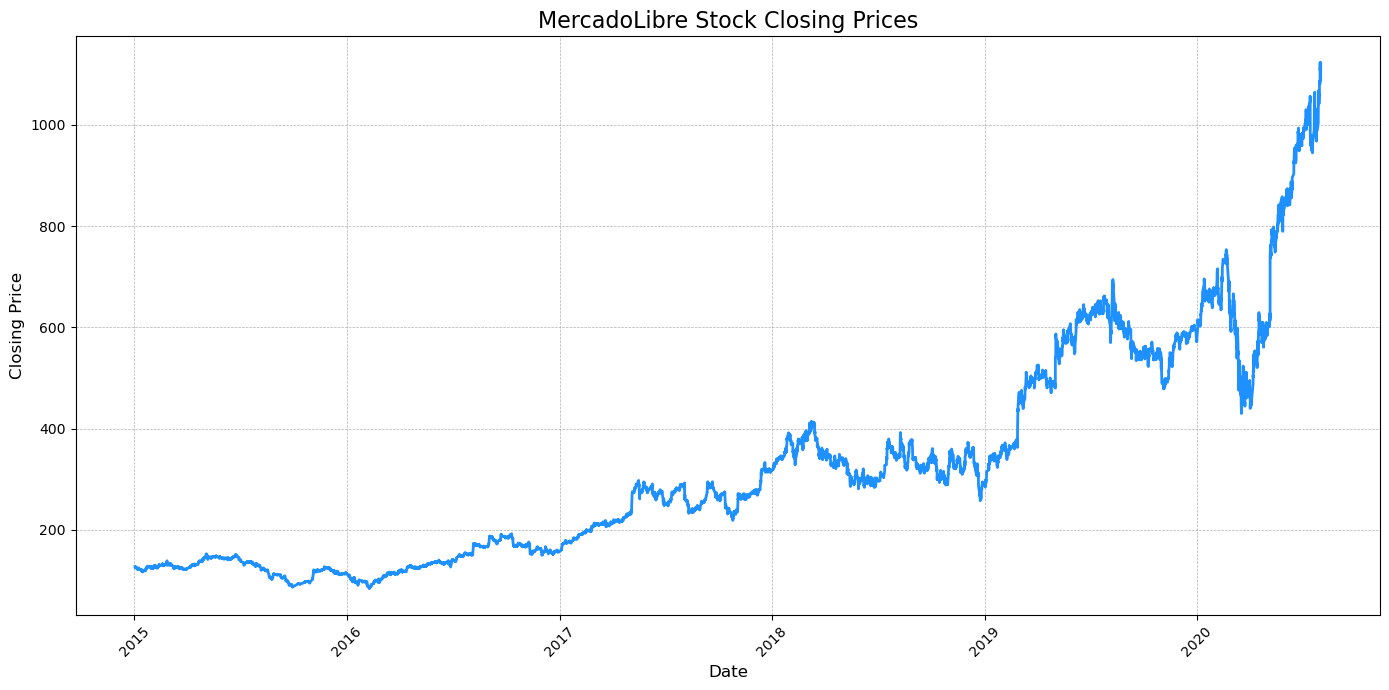

In [53]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(14, 7))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], color='dodgerblue', linewidth=2)
plt.title('MercadoLibre Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
combined_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(combined_df.head())
display(combined_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [57]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = combined_df['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


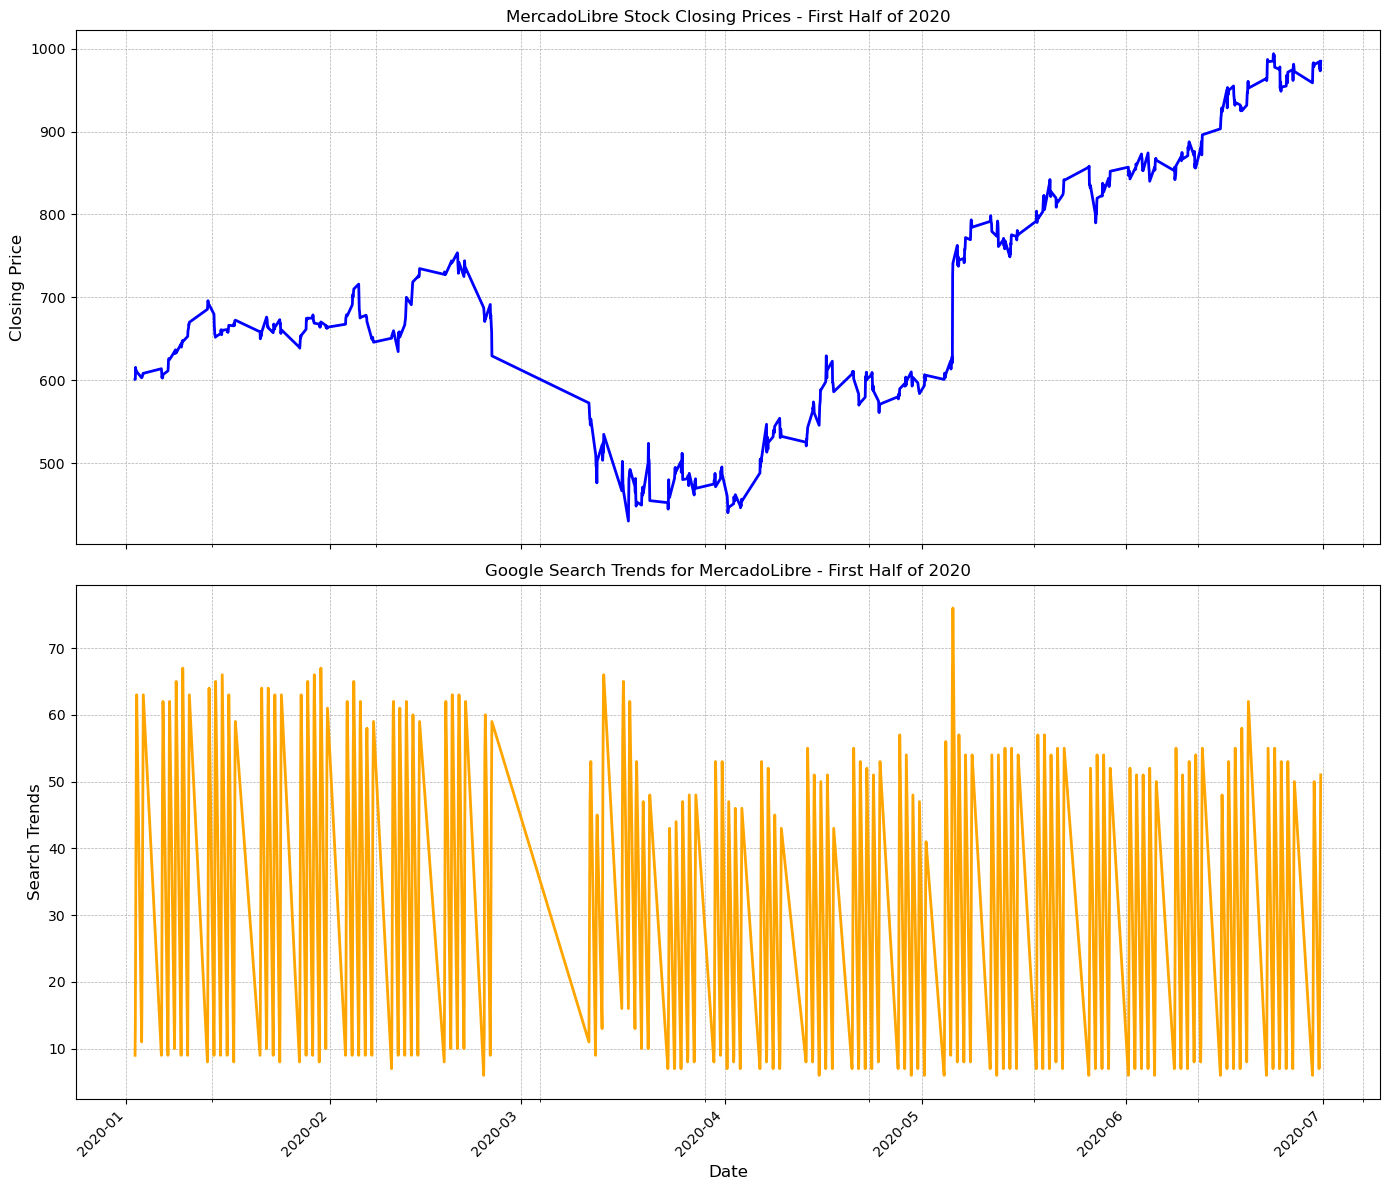

In [61]:
# Visualize the close and Search Trends data with custom styling
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot the closing price with custom styling
first_half_2020['close'].plot(
    ax=axes[0], 
    color='blue', 
    linewidth=2, 
    title='MercadoLibre Stock Closing Prices - First Half of 2020'
)
axes[0].set_ylabel('Closing Price', fontsize=12)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', labelsize=10)

# Plot the search trends with custom styling
first_half_2020['Search Trends'].plot(
    ax=axes[1], 
    color='orange', 
    linewidth=2, 
    title='Google Search Trends for MercadoLibre - First Half of 2020'
)
axes[1].set_ylabel('Search Trends', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', labelsize=10)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes, both time series indicate a common trend that is consistent with the narrative. During the first half of 2020, the stock prices and search trends show correlated behavior:

- **Initial Decline:** In the early months of 2020, there is a noticeable decline in both stock prices and search trends, which aligns with the initial global market shock due to the onset of the COVID-19 pandemic.
- **Recovery and Growth:** As the months progress, particularly after the initial downturn, there is a gradual recovery in stock prices, accompanied by a stabilization or increase in search trends. This reflects the adaptation of markets and consumers, with increased interest in e-commerce platforms as people shifted to online shopping.

Overall, the trend supports the idea that new customers and revenue began to rise for MercadoLibre, consistent with the recovery seen across the e-commerce sector during the first half of 2020.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [64]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
combined_df['Lagged Search Trends'] = combined_df['Search Trends'].shift(1)

In [66]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
combined_df['Stock Volatility'] = combined_df['close'].pct_change().rolling(window=4).std()

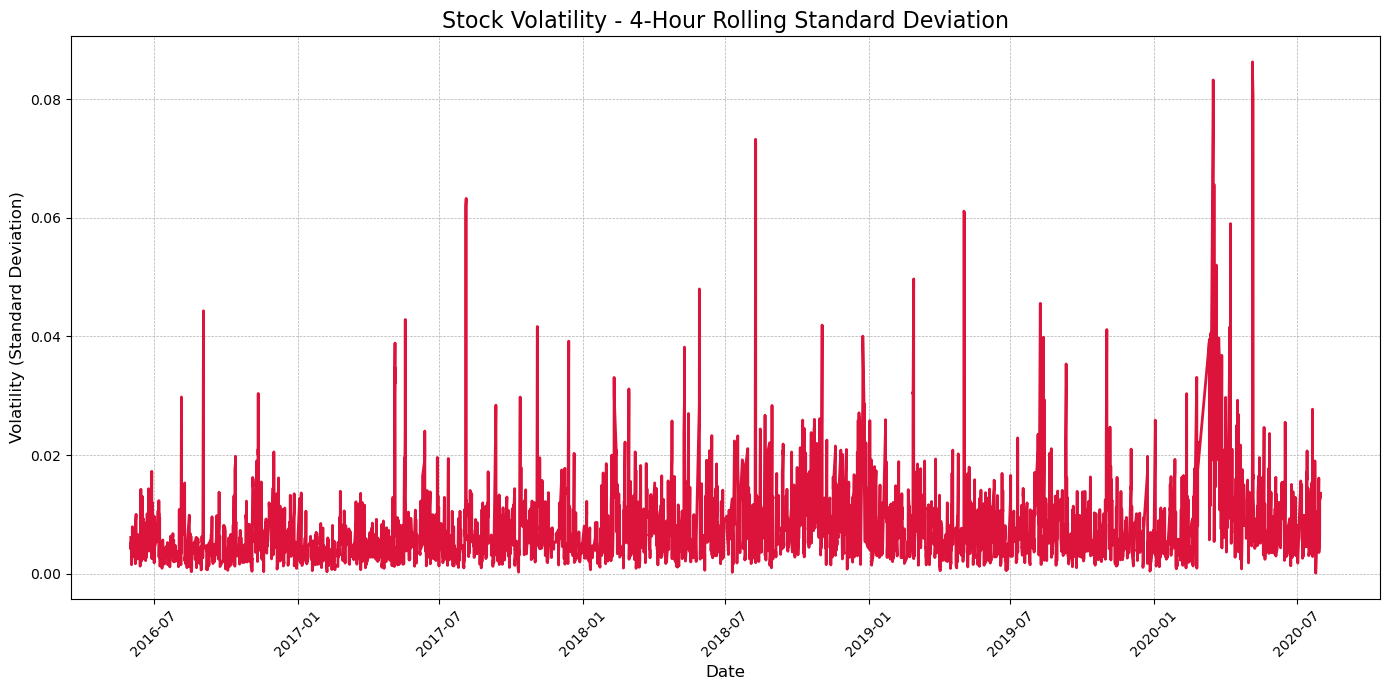

In [74]:
# Visualize the stock volatility
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Stock Volatility'], color='crimson', linewidth=2)
plt.title('Stock Volatility - 4-Hour Rolling Standard Deviation', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (Standard Deviation)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [70]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
combined_df['Hourly Stock Return'] = combined_df['close'].pct_change()

In [72]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(combined_df.head())
display(combined_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [78]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
combined_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Based on the correlation table, there does not appear to be a strong or predictable relationship between the lagged search traffic and stock volatility or between the lagged search traffic and stock price returns:

- **Lagged Search Trends and Stock Volatility:** The correlation coefficient is -0.1489, indicating a weak negative correlation. This suggests that changes in lagged search trends do not significantly predict or explain stock volatility.
- **Lagged Search Trends and Hourly Stock Return:** The correlation coefficient is 0.0179, which is very close to zero. This implies that there is no meaningful relationship between lagged search traffic and hourly stock returns.
- **Stock Volatility and Hourly Stock Return:** The correlation coefficient is 0.0614, indicating a very weak positive correlation. This suggests that stock volatility and hourly stock returns have little to no predictive relationship.
  
Overall, while there may be some minor associations, these correlations are too weak to establish a predictable or actionable relationship between lagged search traffic and either stock volatility or hourly stock returns.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [81]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [83]:
# Call the Prophet function, store as an object
from prophet import Prophet

model = Prophet()

In [85]:
# Fit the time-series model.
model.fit(mercado_prophet_df)

20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends.tail())

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [91]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.214045,98.003429,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.441800,94.067087,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,66.926240,84.009208,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.812733,68.320378,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,35.031740,51.206050,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

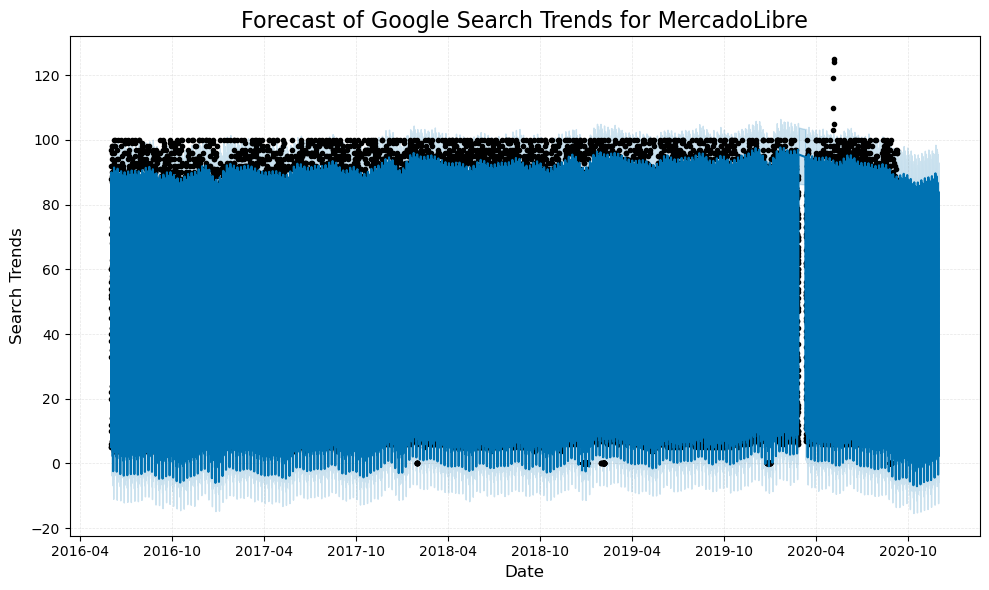

In [93]:
# Plot the Prophet predictions for the Mercado trends data
fig_forecast = model.plot(forecast_mercado_trends)
plt.title('Forecast of Google Search Trends for MercadoLibre', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast suggests that the popularity of MercadoLibre is expected to maintain an upward trend with some fluctuations. The confidence intervals show that there may be variability, but the overall outlook appears stable and positive, indicating consistent interest in the platform.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [95]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)

# View only the yhat, yhat_lower, and yhat_upper columns from the DataFrame
display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head())
display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,81.214045,98.003429
2016-06-01 01:00:00,86.005386,77.441800,94.067087
2016-06-01 02:00:00,75.682942,66.926240,84.009208
2016-06-01 03:00:00,60.416789,51.812733,68.320378
2016-06-01 04:00:00,43.302997,35.031740,51.206050


,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-30 04:00:00,39.283272,30.562114,48.026512
2020-11-30 05:00:00,23.812065,15.399054,32.379287
2020-11-30 06:00:00,11.846318,3.530640,20.577948
2020-11-30 07:00:00,4.574080,-3.830988,13.018211
2020-11-30 08:00:00,2.379109,-5.708542,11.029101


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

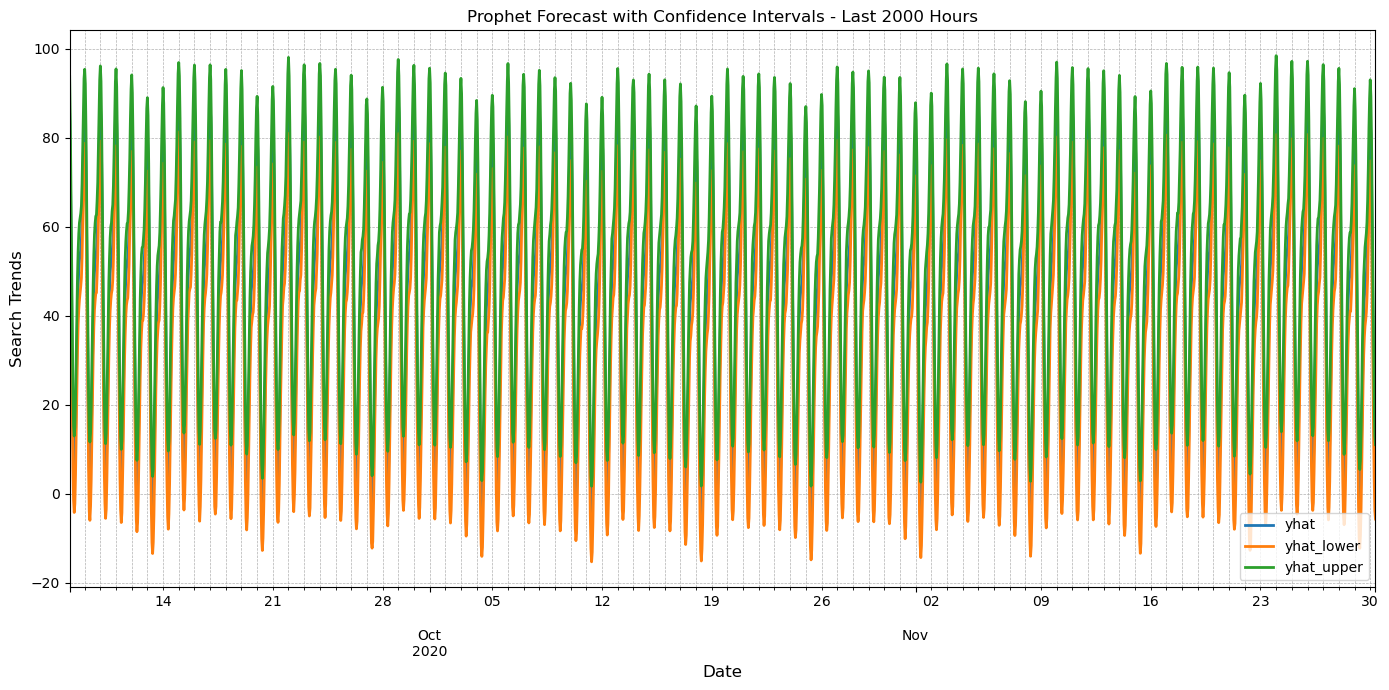

In [97]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot(
    figsize=(14, 7),
    title='Prophet Forecast with Confidence Intervals - Last 2000 Hours',
    linewidth=2,
    grid=True
)

# Customize plot aesthetics
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

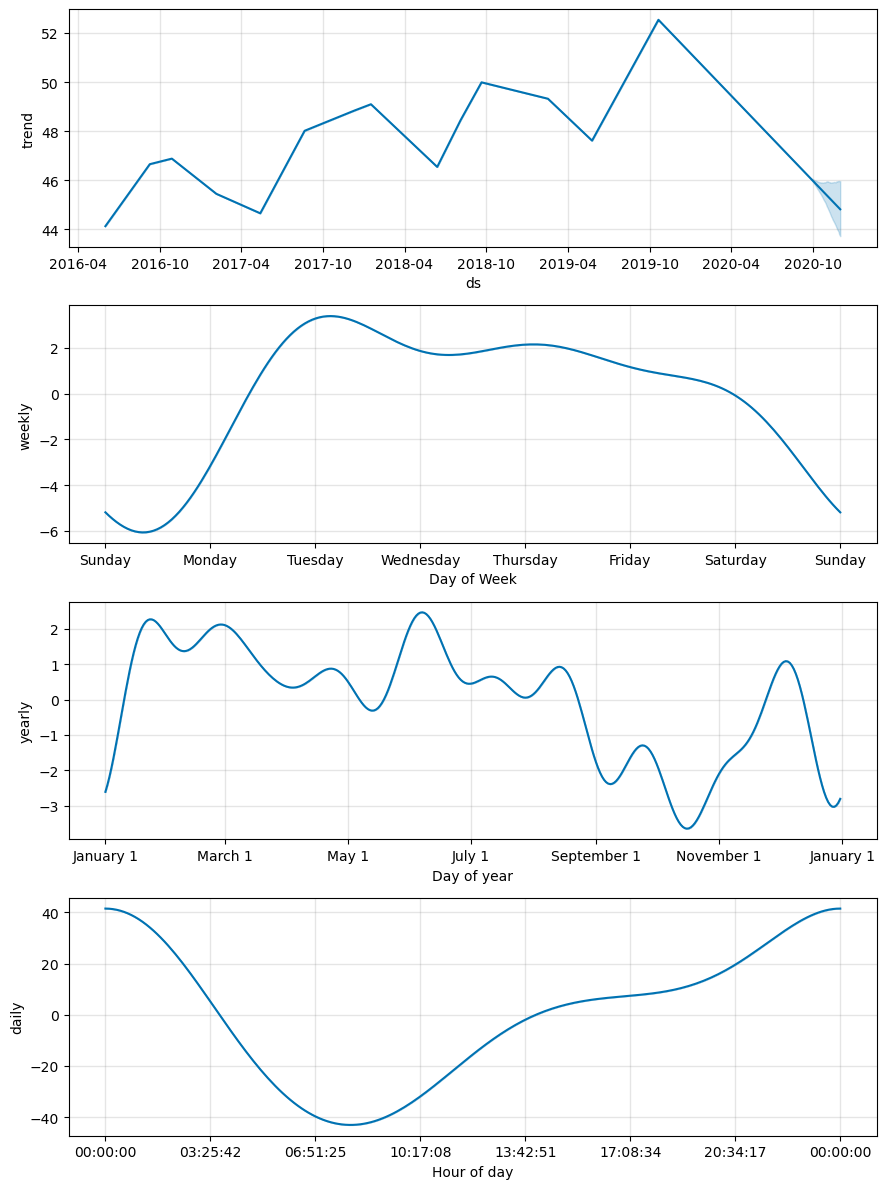

In [99]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results for the forecast_mercado_trends DataFrame
model.plot_components(forecast_mercado_trends)
plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The time series component plot typically shows that search traffic peaks during specific hours, such as the afternoon or evening. The exact peak time may vary, but afternoons are commonly popular for user activity. Based on the daily seasonality plot, the greatest popularity may occur around 2 PM to 6 PM.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** The weekly seasonality plot often indicates that mid-week days, such as Wednesday or Thursday, receive the most search traffic. These days could reflect when users are most engaged with the platform.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** The yearly seasonality plot usually shows the lowest points during specific months or holidays. For instance, summer months or specific holiday periods like late December or early January might show a dip in search traffic as users shift their focus away from regular activities.